<a href="https://colab.research.google.com/github/Ila021/MCIO1/blob/main/Predicci%C3%B3n_de_variables_temporales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de precios de acciones a partir de un modelo LSTM
## Explicación del modelo de forma breve

(Modelo de ejemplo de miles de fuentes de información y la autoría, no es en su totalidad, propia)
# Modelo LSTM para Predicción de Acciones

Los modelos de memoria a largo corto plazo (LSTM) son un tipo de red neuronal recurrente (RNN) capaces de aprender dependencias a largo plazo en secuencias de datos.
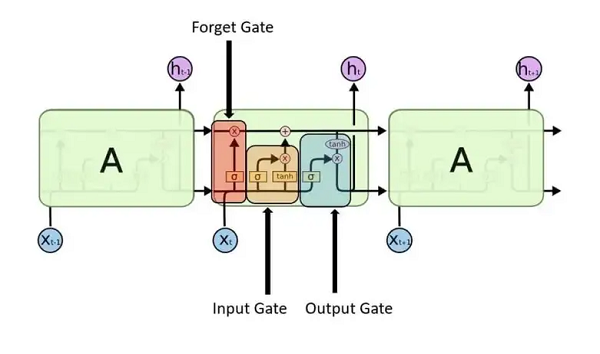
## 1. Fórmulas Matemáticas del LSTM

Un LSTM tiene tres puertas principales:

- **Puerta de Olvido**:
  $$
  f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
  $$
- **Puerta de Entrada**:
  $$
  i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
  $$
- **Candidata de la Celda**:
  $$
  \tilde{C_t} = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)
  $$
- **Estado de la Celda**:
  $$
  C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C_t}
  $$
- **Puerta de Salida**:
  $$
  o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
  $$
- **Estado Oculto**:
  $$
  h_t = o_t \odot \tanh(C_t)
  $$

Donde:
- \( x_t \) es la entrada en el tiempo \( t \).
- \( h_t \) es el estado oculto.
- \( C_t \) es la memoria de la celda.
- \( W \) y \( b \) son los pesos y sesgos aprendidos.
- \( \sigma \) es la función sigmoide y \( \tanh \) es la tangente hiperbólica.


# Vamos a realizar la predicción del precio de la Acción de Apple en un rango de años

In [93]:
import numpy as np
np.random.seed(3)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense

df=pd.read_csv('AAPL_2006-01-01_to_2018-01-01.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
1,2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2,2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
3,2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
4,2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


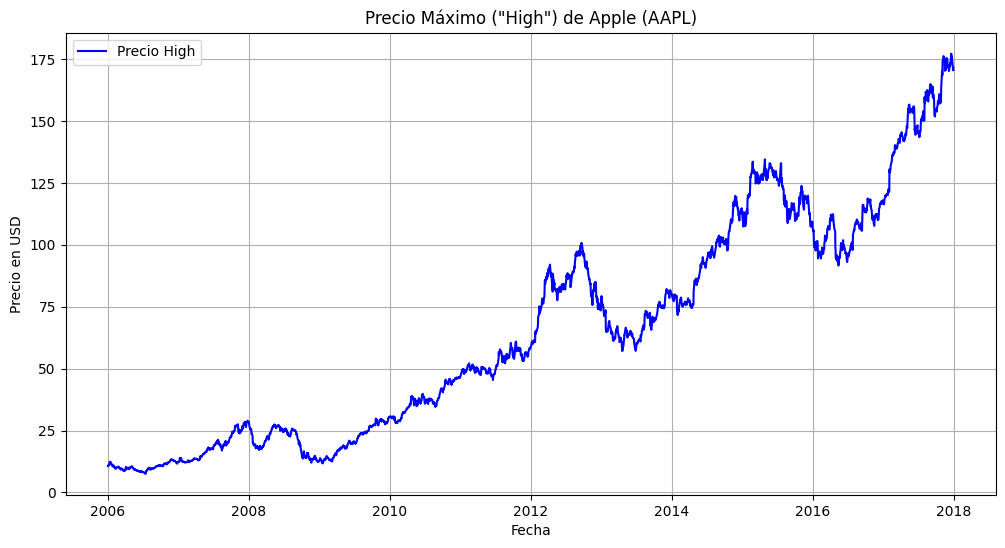

In [94]:
#Componemos el set de entrenamiento y el de test para analizar cómo de bueno es el modelo
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
train_set = df.loc[df.index < '2017', ['High']].values  # Convertir a array
test_set = df.loc[df.index >= '2017', ['High']].values

#Debemos de escalar los datos del 0 al 1 para poder analizar de forma correcta el modelo
from sklearn.preprocessing import MinMaxScaler
escalar=MinMaxScaler(feature_range=(0,1))
train_set_scale=escalar.fit_transform(train_set)
test_set_scale=escalar.transform(test_set)
# Graficar el precio máximo ("High")
plt.figure(figsize=(12,6))
plt.plot(df.index, df['High'], label='Precio High', color='blue')

# Personalización del gráfico
plt.title('Precio Máximo ("High") de Apple (AAPL)')
plt.xlabel('Fecha')
plt.ylabel('Precio en USD')
plt.legend()
plt.grid(True)

# Mostrar gráfico
plt.show()

# Vamos a prepara los datos de entrada y salida del modelo para poder predecir el valor buscado

Trabajaremos con los datos anteriores que serán las variables de entrada del modelo y los datos de salida seran los datos futuros del modelo de serie temporal (Vamos a trabajar con un intervalo de 100 variables para considerar un número razonable)

In [95]:
steps=100
Xtrain=[]
Ytrain=[]

a=len(train_set_scale)

for j in range(steps,a):
    Xtrain.append(train_set_scale[j-steps:j,0])
    Ytrain.append(train_set_scale[j,0])

Xtrain,Ytrain=np.array(Xtrain),np.array(Ytrain)

#Debemos de transponer el vector que acabamos de crear para introducirlo en el modelo que hemos creado
Xtrain=np.reshape(Xtrain,(Xtrain.shape[0],Xtrain.shape[1],1))

# Creación del modelo de predicción

In [96]:
#Definimos la dimensión del modelo
dim_salida=1
dim_entrada=Xtrain.shape[1],1

#Definimos el número de neuronas que queremos establecer en nuestro modelo
neuronas=100
#Definimos el modelo
m=Sequential()
m.add(LSTM(units=neuronas, input_shape=dim_entrada))
m.add(Dense(units=dim_salida))
#Compilamos el modelo
m.compile(optimizer='rmsprop',loss='mean_squared_error')
#Entrenamos el modelo
m.fit(Xtrain,Ytrain,epochs=10,batch_size=32)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 0.0303
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - loss: 0.0014
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 7.9208e-04
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 6.8879e-04
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 7.9462e-04
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 5.3308e-04
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 6.2480e-04
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 4.7779e-04
Epoch 9/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 4.9050e-04
Epoch 10/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - loss: 4.8030e-04


# Comprobación del modelo con datos historicos más recientes

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


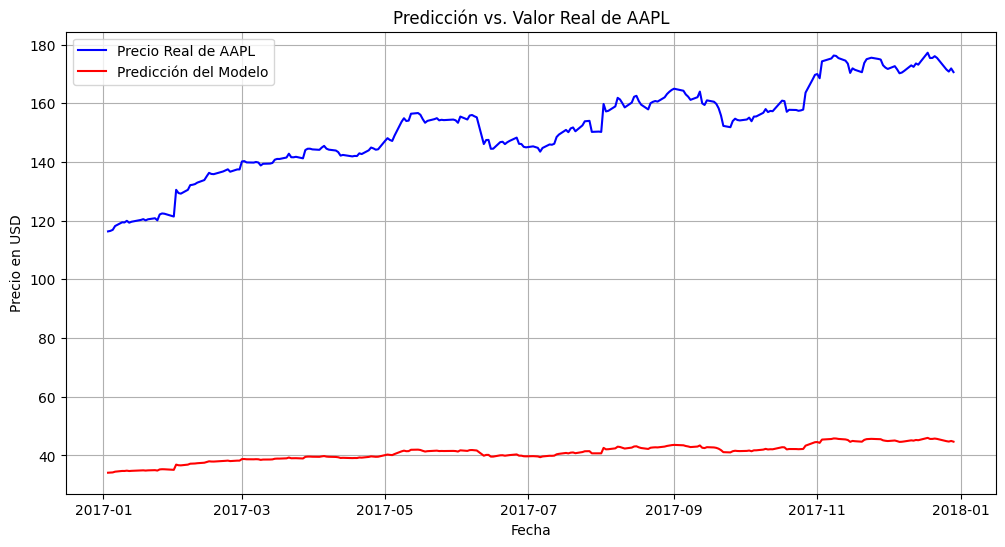

In [99]:
X_test=test_set_scale
x_test = []
for i in range(steps,len(X_test)):
    x_test.append(X_test[i-steps:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

#Comprobación del modelo predicciones
prediccion = m.predict(X_test)
#Invertimos la transformación realizada
prediccion = escalar.inverse_transform(prediccion)

real = escalar.inverse_transform(test_set_scale)  # Valores reales

# Graficar los valores reales vs. predichos
plt.figure(figsize=(12,6))
plt.plot(df.index[-len(real):], real, color='blue', label='Precio Real de AAPL')
plt.plot(df.index[-len(prediccion):], prediccion, color='red', label='Predicción del Modelo')

# Personalización del gráfico
plt.title('Predicción vs. Valor Real de AAPL')
plt.xlabel('Fecha')
plt.ylabel('Precio en USD')
plt.legend()
plt.grid(True)

# Mostrar el gráfico
plt.show()